In [38]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools, viz_tools
import xarray as xr
import datetime
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV18-01'
nowcast_data = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)
nowcast = xr.open_dataset(nowcast_data)

In [19]:
nowcast_salinity = nowcast.salinity

In [41]:
ferry = pd.read_csv('https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV18-01.csv?time%2Clongitude%2Clatitude%2Csalinity&time%3E=2014-09-13T00%3A00%3A00Z&time%3C=2018-01-08T23%3A59%3A00Z')
ferry = ferry.drop(ferry.index[0])

/home/vdo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'
import os
ferry = ferry.dropna()

In [43]:
ferry.keys()

Index(['time', 'longitude', 'latitude', 'salinity'], dtype='object')

In [75]:
list_of_model_sals = np.array([])
list_of_ferry_sals = np.array([])
list_of_lons = np.array([])
#unit = ferry.variables['s.time'].units
for n in ferry.index: #2563687):
    #if ((ferry.variables['s.latitude'][n].mask == False) 
        #and (ferry.variables['s.chlorophyll'][n].mask == False)):
    Yind, Xind = geo_tools.find_closest_model_point(float(ferry.longitude[n]), 
                                                    float(ferry.latitude[n]), 
                                                    X, Y, land_mask = bathy.mask)
    date = datetime.datetime.strptime(ferry.time[n][:-1], '%Y-%m-%dT%H:%M:%S')
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date - before).seconds / 3600
        sal_val = ((1-delta)*nuts.variables['vosaline'][before.hour, 1, Yind, Xind] + 
                   (delta)*(nuts2.variables['vosaline'][after.hour, 1, Yind, Xind] ))
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date - before).seconds / 3600
        sal_val = ((1-delta)*nuts.variables['vosaline'][before.hour, 1, Yind, Xind] + 
                   (delta)*(nuts2.variables['vosaline'][after.hour, 1, Yind, Xind] ))
    list_of_ferry_sals = np.append(list_of_ferry_sals, float(ferry.salinity[n]))
    list_of_model_sals = np.append(list_of_model_sals, sal_val)
    list_of_lons = np.append(list_of_lons, float(ferry.longitude[n]))

In [4]:
import pickle

In [16]:
output = open('ferry_sal.pkl', 'wb')
pickle.dump(list_of_ferry_sals, output)
output.close()
output = open('model_sal.pkl', 'wb')
pickle.dump(list_of_model_sals, output)
output.close()
output = open('lons.pkl', 'wb')
pickle.dump(list_of_lons, output)
output.close()

In [76]:
list_of_lons.shape

(715021,)

In [77]:
list_of_ferry_sals.shape

(715021,)

In [8]:
list_of_model_sals = pickle.load(open('../model_sal.pkl', 'rb'))
list_of_ferry_sals = pickle.load(open('../ferry_sal.pkl', 'rb'))
list_of_lons = pickle.load(open('../lons.pkl', 'rb'))

In [9]:
print(list_of_lons.min())
print(list_of_lons.max())

-123.95535
-123.0844


In [78]:
bounds = np.linspace(list_of_lons2.min(), list_of_lons2.max(), 11)

In [63]:
from matplotlib.colors import LogNorm

In [79]:
def make_plot(n):
    fig, ax = plt.subplots(figsize = (10,10))
    c, xedge, yedge, im = ax.hist2d(list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons2< bounds[n+1])], 
                                    list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons< bounds[n+1])], 
                                    bins = 100, norm=LogNorm())
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Ferry Data')
    ax.set_ylabel('Nowcast-green')
    ax.plot(np.arange(0,35), 'r-')
    ax.set_title(str(bounds[n]) + ' < lon < ' + str(bounds[n+1]))
    print('bias =  ' + str(-np.mean(list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                       & (list_of_lons< bounds[n+1])]) + 
                           np.mean(list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                      & (list_of_lons< bounds[n+1])])))
    print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                             &  (list_of_lons< bounds[n+1])] - 
                                          list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                             & (list_of_lons< bounds[n+1])])**2) 
                                  / len(list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                           &  (list_of_lons< bounds[n+1])]))))
    xbar = np.mean(list_of_ferry_sals[(bounds[n]<=list_of_lons) &  (list_of_lons< bounds[n+1])])
    print('Willmott = ' + str(1-(np.sum((list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                            & (list_of_lons< bounds[n+1])] - 
                                         list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                            &  (list_of_lons< bounds[n+1])])**2)  / 
                                 np.sum((np.abs(list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                                   &  (list_of_lons< bounds[n+1])] 
                                                - xbar) 
                                         + np.abs(list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                                     &  (list_of_lons< bounds[n+1])] 
                                                  - xbar))**2))))

bias =  1.66856979031
RMSE = 4.92462599804
Willmott = 0.782013448965


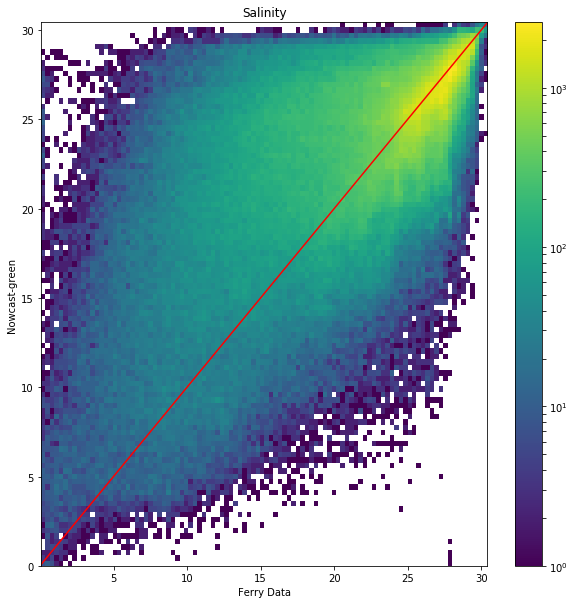

In [98]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_sals, 
                                list_of_model_sals, 
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Nowcast-green')
ax.plot(np.arange(0,35), 'r-')
ax.set_title('Salinity')
print('bias =  ' + str(-np.mean(list_of_ferry_sals) + np.mean(list_of_model_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sals - list_of_ferry_sals)**2) / 
                              len(list_of_model_sals))))
xbar = np.mean(list_of_ferry_sals)
print('Willmott = ' + str(1-(np.sum((list_of_model_sals - list_of_ferry_sals)**2)  / 
                             np.sum((np.abs(list_of_model_sals - xbar) 
                                     + np.abs(list_of_ferry_sals - xbar))**2))))

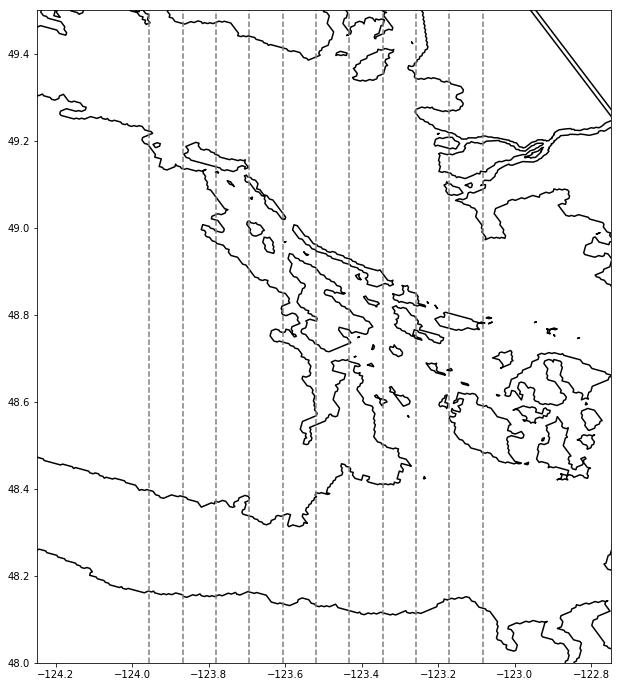

In [80]:
fig, ax = plt.subplots(figsize = (12,12))
viz_tools.plot_coastline(ax, grid, coords = 'map')
viz_tools.set_aspect(ax, coords = 'map')
ax.set_xlim(-124.25, -122.75)
ax.set_ylim(48, 49.5)
for p in range(11):
    ax.plot((bounds[p], bounds[p]), (48, 49.5), '--', color = 'grey')

bias =  -0.194377607837
RMSE = 3.47493630077
Willmott = 0.671300651096


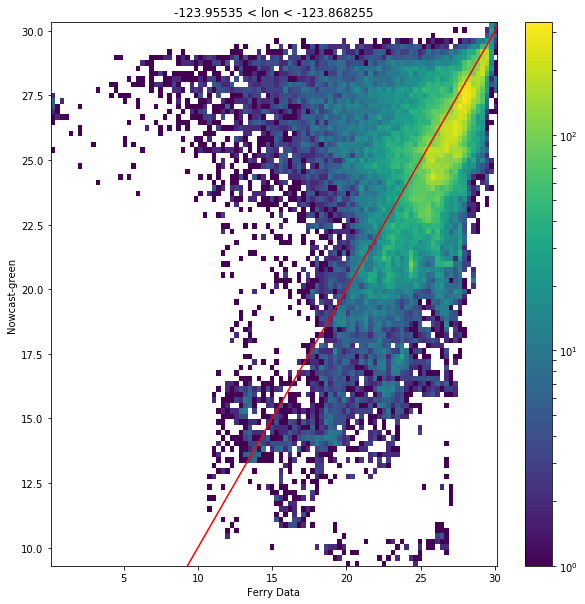

In [82]:
make_plot(0)

bias =  -0.593519827674
RMSE = 2.62248530749
Willmott = 0.787866750802


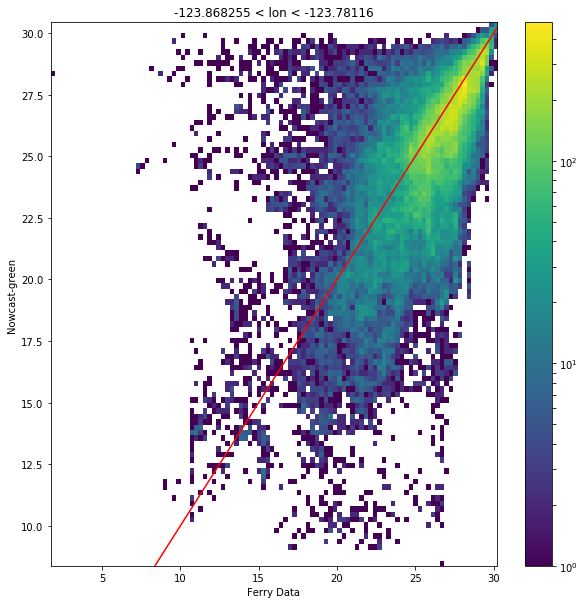

In [83]:
make_plot(1)

bias =  -0.608933761865
RMSE = 2.47063887351
Willmott = 0.813574305729


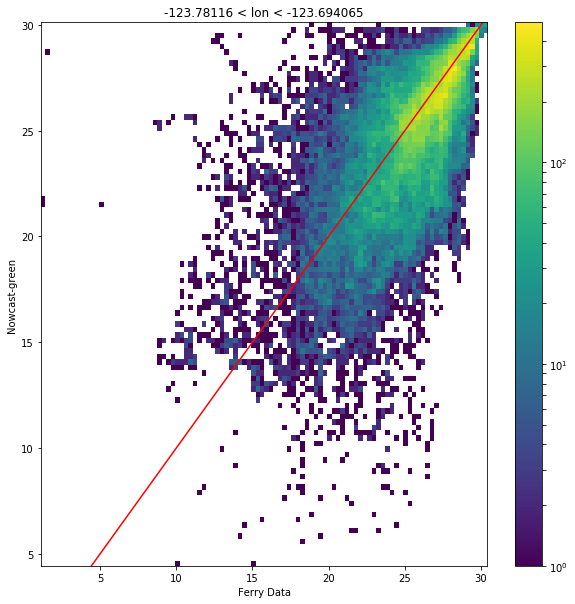

In [84]:
make_plot(2)

bias =  0.643258758667
RMSE = 3.49596231162
Willmott = 0.770953337192


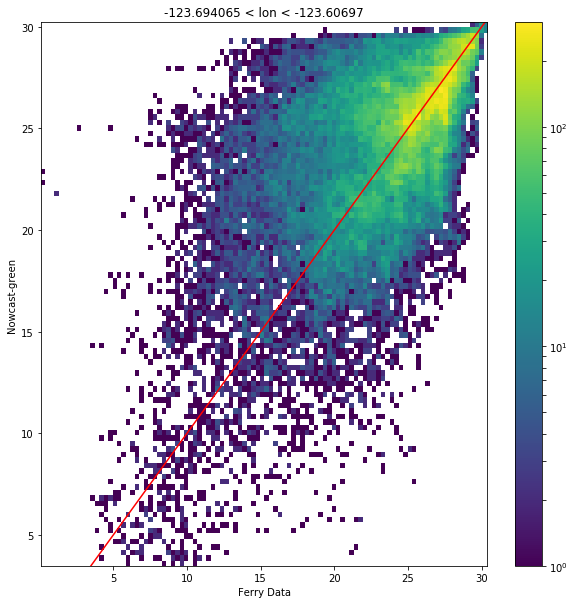

In [85]:
make_plot(3)

bias =  2.28300274631
RMSE = 4.95016797315
Willmott = 0.722419353156


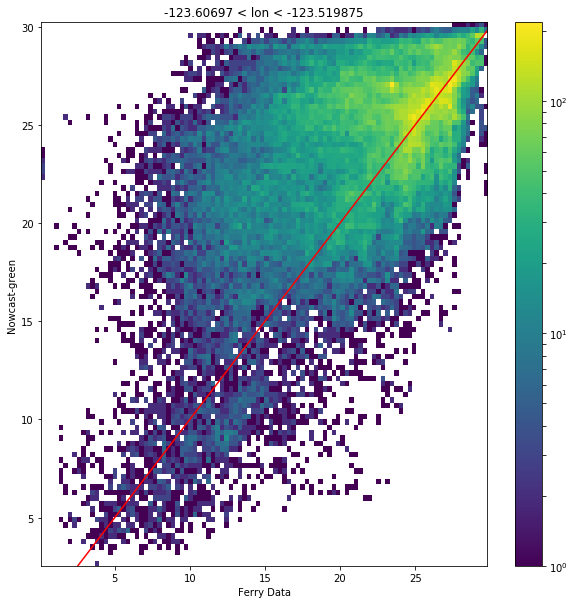

In [86]:
make_plot(4)

bias =  4.03841017809
RMSE = 6.50794667134
Willmott = 0.673618297025


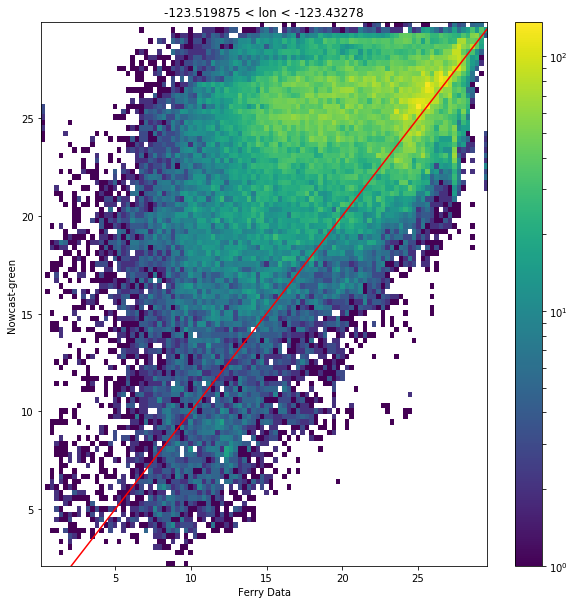

In [87]:
make_plot(5)

bias =  5.16758033788
RMSE = 7.4497717004
Willmott = 0.680863445623


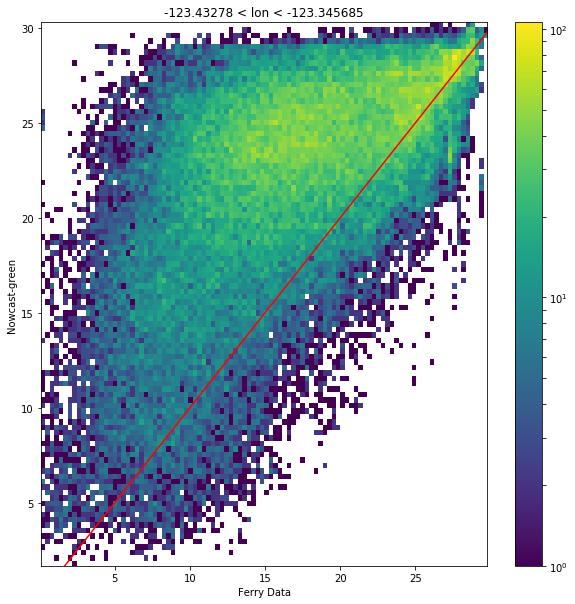

In [88]:
make_plot(6)

bias =  3.16301374669
RMSE = 5.78827641222
Willmott = 0.801244440856


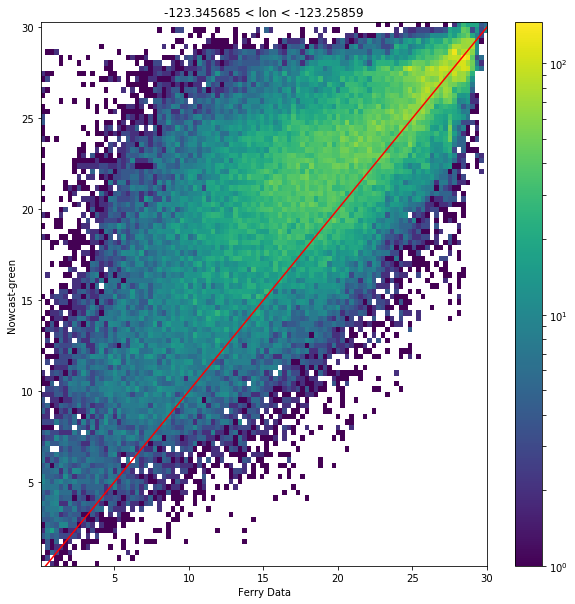

In [89]:
make_plot(7)

bias =  1.4589082344
RMSE = 4.82580255972
Willmott = 0.822053268011


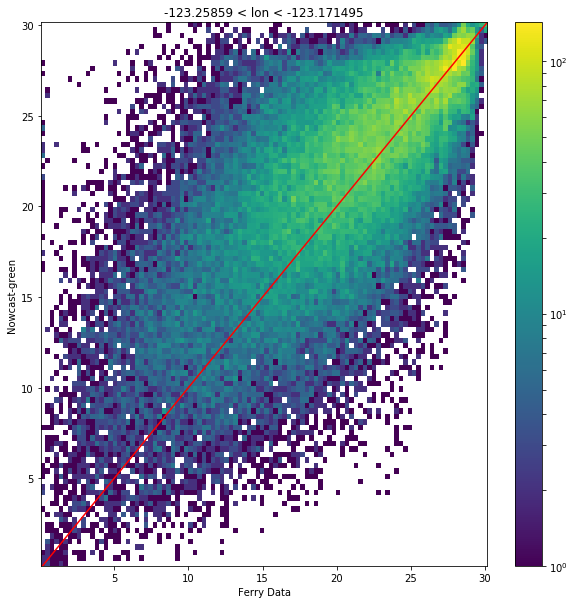

In [90]:
make_plot(8)

bias =  -0.469259816638
RMSE = 4.03603005707
Willmott = 0.755213496942


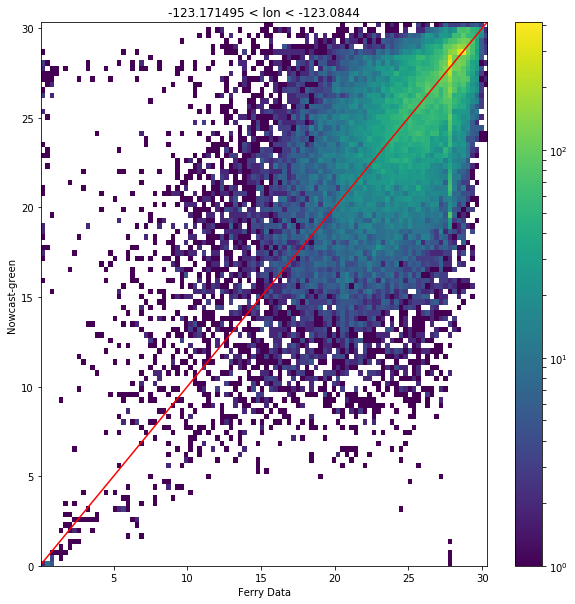

In [91]:
make_plot(9)

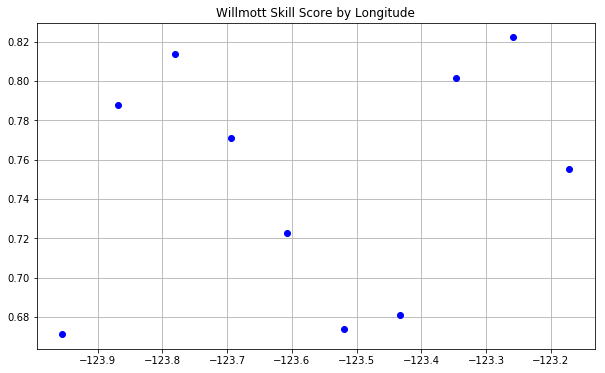

In [93]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(bounds[:-1], [0.671300651096, 0.787866750802, 0.813574305729,0.770953337192,0.722419353156,
                      0.673618297025,0.680863445623,0.801244440856,0.822053268011,0.755213496942], 'bo')
ax.grid('on')
ax.set_title('Willmott Skill Score by Longitude')

In [94]:
bounds

array([-123.95535 , -123.868255, -123.78116 , -123.694065, -123.60697 ,
       -123.519875, -123.43278 , -123.345685, -123.25859 , -123.171495,
       -123.0844  ])

In [96]:
import pickle

In [97]:
output = open('bounds.pkl', 'wb')
pickle.dump(bounds, output)
output.close()